In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
ownership = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/ownership/infoboxUNCOwnership.csv").rename(columns={"ogName":"source"})

In [4]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/prohttps://eribean.github.io/girth/docs/quickstart/quickstart/jects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"])

<ipython-input-4-0d2084b2e61c>:6: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  merged = pd.read_csv(IN_PATH, sep="\t")


In [5]:
#merge ownership onto our news data 
merged = pd.merge(merged, ownership[["source", "cleanedOwner"]], on="source", how="left")

In [6]:
merged.head(3)

,Unnamed: 0,key,local_id,sourcedomain_id,date,title,content,url,fips,source,...,predrt_3,national,id,author,published,published_utc,collection_utc,year,clustNum,cleanedOwner
0,2,2,andalusiastarnews--2020-04-04--Governor issues...,andalusiastarnews-andalusiastarnews.com,2020-04-04,Governor issues stay at home order,Governor Kay Ivey announced that a stay at hom...,https://www.andalusiastarnews.com/2020/04/03/g...,1039.0,andalusiastarnews,...,30.80,False,NaN,NaN,NaN,NaN,NaN,2020,7.0,Boone Newspapers
1,12,12,atmoreadvance--2020-04-03--COVID-19: Statewide...,atmoreadvance-atmoreadvance.com,2020-04-03,COVID-19: Statewide ‘stay-at-home’ order issued,State officials issued a statewide stay-at-hom...,https://www.atmoreadvance.com/2020/04/03/covid...,1053.0,atmoreadvance,...,31.68,False,NaN,NaN,NaN,NaN,NaN,2020,7.0,Boone Newspapers
2,20,20,thebrewtonstandard--2020-04-03--Gov. Ivey issu...,thebrewtonstandard-brewtonstandard.com,2020-04-03,Gov. Ivey issues Stay at Home Order,Governor Kay Ivey on Friday issued a Stay at H...,https://www.brewtonstandard.com/2020/04/03/gov...,1053.0,thebrewtonstandard,...,31.68,False,NaN,NaN,NaN,NaN,NaN,2020,7.0,NaN


In [7]:
#create list of clusters and their % national coverage 
def getFirst(inList): 
    return inList[0]

natPercent = merged[["key", "national", "clustNum"]].groupby("clustNum").agg({"key":list, "national":np.mean}).rename(columns={"national":"natPercent"})


In [8]:
natPercent["clustSize"] = natPercent["key"].apply(len)

In [9]:
natPercent = natPercent.explode(column="key")

In [10]:
natPercent.head(3)

,key,natPercent,clustSize
clustNum,,,
0.0,12619,0.949721,1253
0.0,28945,0.949721,1253
0.0,43496,0.949721,1253


In [11]:
#merge in the cluster level information into the original 
#article level data 
merged = pd.merge(merged, natPercent, on="key", how="left")

## H1: Do owned newspapers take part in national coverage more

In [12]:
#figure out which outlets are owned by larger firms
ownershipCounts = ownership[["source", "cleanedOwner"]].groupby("cleanedOwner").agg(len).sort_values("source", ascending=False)
ownershipCounts = ownershipCounts[ownershipCounts["source"] >= 10]
topOwners = list(ownershipCounts.index)
topOwners

['Gannett', 'Boone Newspapers', 'Forum Communications', 'Digital First Media']

In [13]:
merged["largeOwner"] = merged["cleanedOwner"].isin(topOwners)
local = merged[merged["national"] == False]
local = local[(local["clustSize"] < 3000) & (local["clustSize"] > 5)]
local["largeOwner"].value_counts()

largeOwner
False    100615
True      46200
Name: count, dtype: int64

In [14]:
largeOwned = local.loc[local["largeOwner"] == True, "natPercent"] 
print(np.mean(largeOwned))
print(np.median(largeOwned))
print(np.std(largeOwned))

0.20298464165290134
0.06845965770171149
0.26223598193737063


In [15]:
smallOwned = local.loc[local["largeOwner"] == False, "natPercent"]
print(np.mean(smallOwned))
print(np.median(smallOwned))
print(np.std(smallOwned))

0.29805722861869755
0.2188679245283019
0.31314698614036407


In [16]:
len(largeOwned)

46200

(0.0, 20000.0)

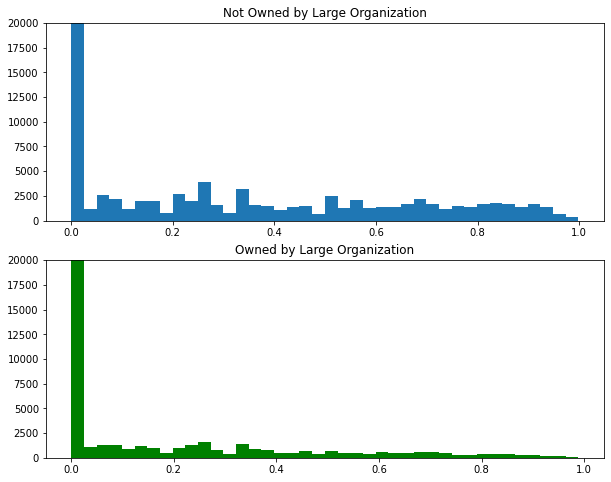

In [17]:
fig, axs = plt.subplots(2, figsize=(10, 8))
axs[0].hist(smallOwned, bins=40)
axs[0].set_title("Not Owned by Large Organization")
axs[0].set_ylim(0, 20000)
axs[1].hist(largeOwned, bins=40, color="green")
axs[1].set_title("Owned by Large Organization")
axs[1].set_ylim(0, 20000)

(0.0, 5.0)

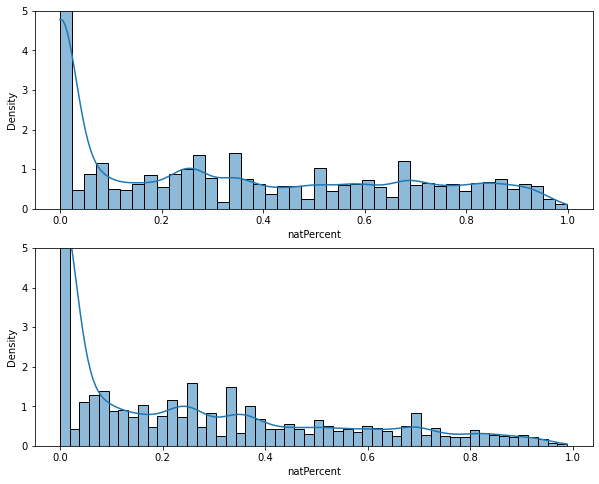

In [18]:
fig, axs = plt.subplots(2, figsize=(10, 8))
sns.histplot(x=smallOwned, stat="density", kde=True, ax=axs[0])
sns.histplot(x=largeOwned, stat="density", kde=True, ax=axs[1])
axs[0].set_ylim(0, 5)
axs[1].set_ylim(0, 5)

Text(0, 0.5, 'Density')

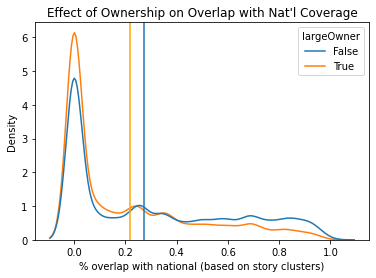

In [22]:
plt.title("Effect of Ownership on Overlap with Nat'l Coverage")
sns.kdeplot(x="natPercent", hue="largeOwner", common_norm=False, data=local)
plt.axvline(.2748)
plt.axvline(.2179, color="orange")
plt.xlabel("% overlap with national (based on story clusters)")
plt.ylabel("Density")

In [194]:
print(np.mean(smallOwned))
print(np.mean(largeOwned))

0.2748503419041861
0.21793656194758124


In [197]:
local["hasNat"] = local["natPercent"] > 0

<ipython-input-197-148439952a2e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local["hasNat"] = local["natPercent"] > 0


In [198]:
print(np.mean(local.loc[local["largeOwner"] == True, "hasNat"]))why
print(np.mean(local.loc[local["largeOwner"] == False, "hasNat"]))

0.5852925885275259
0.6276176797627873


In [184]:
#interestingly, a smaller proportion of articles from outlets owned by Gannett 
#overlap with national coverage clusters 

In [233]:
#now look at just Gannett

In [25]:
merged["gannettOwned"] = merged["cleanedOwner"] == "Gannett"
local = merged[merged["national"] == False]
local = local[(local["clustSize"] < 3000) & (local["clustSize"] > 5)]
local["gannettOwned"].value_counts()

gannettOwned
False    129504
True      17311
Name: count, dtype: int64

Text(0, 0.5, 'Density')

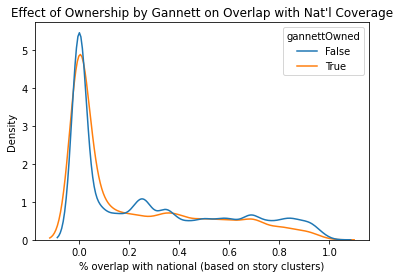

In [26]:
plt.title("Effect of Ownership by Gannett on Overlap with Nat'l Coverage")
sns.kdeplot(x="natPercent", hue="gannettOwned", common_norm=False, data=local)
plt.xlabel("% overlap with national (based on story clusters)")
plt.ylabel("Density")

Index(['Unnamed: 0', 'key', 'local_id', 'sourcedomain_id', 'date', 'title',
       'content', 'url', 'fips', 'source', 'description', 'onlinesince',
       'rank', 'state', 'city', 'lon', 'lat', 'county', 'total_population',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', 'year', 'clustNum', 'cleanedOwner', 'natPercent',
       'clustSize', 'largeOwner', 'gannettOwned'],
      dtype='object')

In [41]:
allOwnerCounts = ownership[["source", "cleanedOwner"]].groupby("cleanedOwner").agg(len).sort_values("source", ascending=False).reset_index()
allOwnerCounts = allOwnerCounts.rename(columns={"source":"ownerCount"})

In [42]:
localOwners = pd.merge(local, allOwnerCounts, on="cleanedOwner", how="right")

In [53]:
allOwnerCounts.head(10)

,cleanedOwner,ownerCount
0,Gannett,34
1,Boone Newspapers,13
2,Forum Communications,10
3,Digital First Media,10
4,Sound Publishing,9
5,AIM Media,7
6,Black Press Group,5
7,Morris Multimedia,5
8,Champion Media,4
9,Tribune/Digital First,3


In [46]:
natOverlapOwnership = localOwners[["source", "natPercent", "ownerCount"]].groupby("source").agg(np.mean)

Text(0.5, 1.0, "Owner size and overlap with nat'l coverage")

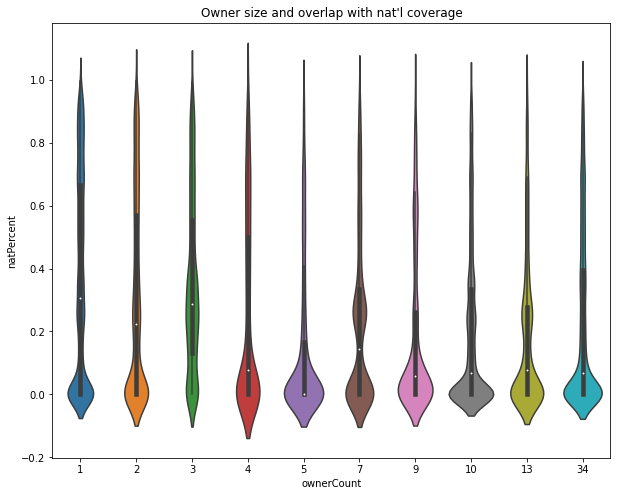

In [52]:
fig, axs = plt.subplots(figsize=(10, 8))
sns.violinplot(x="ownerCount", y="natPercent", data=localOwners, alpha=.3)
plt.title("Owner size and overlap with nat'l coverage")


## H4: does overlap with conservative versus liberal media differ based on ownership? 

In [84]:
## bring in ideology data
ideology = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/politicalSlant/national2020slant.csv")
ideology = ideology.drop(columns=["Unnamed: 0"]).rename(columns={"sourceCleaned":"source"})

In [85]:
#we have info for 261,460 out of 908,027 outlets 

In [86]:
idDf = pd.merge(merged, ideology, on="source", how="right")

In [87]:
idDf = idDf[["clustNum", "rating_num"]].groupby("clustNum").agg(np.mean).reset_index().rename(columns={"rating_num":"avgRating"})

In [116]:
idMerged = pd.merge(merged, idDf, on="clustNum", how="right")

In [126]:
idMerged = idMerged[idMerged["clustSize"] < 3000]

In [127]:
#and we are able to get some score for 822,599 of our ~1.3 million articles 

In [128]:
len(idMerged[idMerged["national"] == False])

70341

In [129]:
idMerged = pd.merge(idMerged, allOwnerCounts, on="cleanedOwner", how="right")

In [130]:
idMerged["largeOwner"] = idMerged["largeOwner"].astype(str)

<Axes: xlabel='avgRating', ylabel='Probability'>

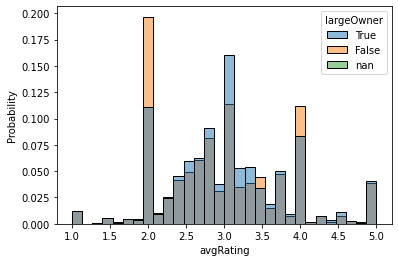

In [131]:
sns.histplot(x="avgRating", hue="largeOwner", common_norm = False, stat="probability", bins=30, data=idMerged)
plt.title("Ownership and overlap with national partisan content")
plt.xlabel("partisanship rating (liberal -- > conservative)")

In [133]:
idMerged["gannettOwned"] = idMerged["gannettOwned"].astype(str)

Text(0.5, 0, 'partisanship rating (liberal -- > conservative)')

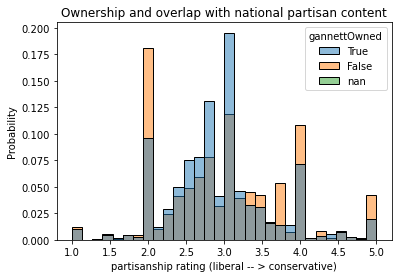

In [141]:
sns.histplot(x="avgRating", hue="gannettOwned", common_norm = False, stat="probability", bins=30, data=idMerged)
plt.title("Ownership and overlap with national partisan content")
plt.xlabel("partisanship rating (liberal -- > conservative)")

In [136]:
idMerged["ownerCount_x"] > 1

0        34.0
1        34.0
2        34.0
3        34.0
4        34.0
         ... 
76108     1.0
76109     1.0
76110     1.0
76111     1.0
76112     1.0
Name: ownerCount_x, Length: 76113, dtype: float64

<Axes: xlabel='avgRating', ylabel='Probability'>

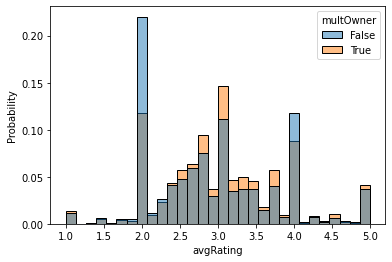

In [139]:
idMerged["multOwner"] = idMerged["ownerCount_x"] >= 2
sns.histplot(x="avgRating", hue="multOwner", common_norm = False, stat="probability", bins=30, data=idMerged)

<Axes: xlabel='avgRating', ylabel='Density'>

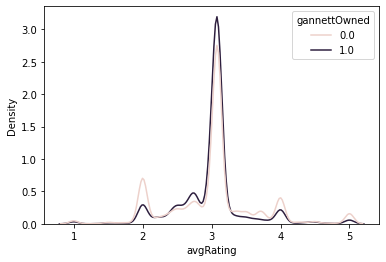

In [104]:
sns.kdeplot(x="avgRating", hue="gannettOwned", common_norm = False, data=idMerged)

## Additional Hypotheses: 
- can we look into content and see what the difference in covered topics is? 
- what about story duration? 
- overlap with different types of national content perhaps? 